In [ ]:
!pip install --no-cache-dir -q pillow matplotlib

In [ ]:
import logging
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.python.saved_model import tag_constants

logging.basicConfig(level=logging.INFO, 
                    format='%(asctime)s-%(levelname)s:%(message)s')
logging.info("Tensorflow Version: {}".format(tf.__version__))

In [ ]:
!nvidia-smi

In [2]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
!dpkg -l | grep nvinfer

ii  libnvinfer-bin              7.0.0-1+cuda10.2                    amd64        TensorRT binaries
ii  libnvinfer-dev              7.0.0-1+cuda10.2                    amd64        TensorRT development libraries and headers
ii  libnvinfer-plugin-dev       7.0.0-1+cuda10.2                    amd64        TensorRT plugin libraries
ii  libnvinfer-plugin7          7.0.0-1+cuda10.2                    amd64        TensorRT plugin libraries
ii  libnvinfer7                 7.0.0-1+cuda10.2                    amd64        TensorRT runtime libraries
ii  python3-libnvinfer          7.0.0-1+cuda10.2                    amd64        Python 3 bindings for TensorRT
ii  python3-libnvinfer-dev      7.0.0-1+cuda10.2                    amd64        Python 3 development package for TensorRT


# TF-TRT FP32 Model

In [4]:
outputTensorrtPath = "/tmp/mcclust/mnist_tensorrt"
assert os.path.exists(outputTensorrtPath)

In [5]:
!saved_model_cli show --all --dir {outputTensorrtPath}

2020-10-05 07:21:37.167810: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.2
2020-10-05 07:21:37.843199: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer.so.7
2020-10-05 07:21:37.844310: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libnvinfer_plugin.so.7

MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_2'] tensor_info:
        dtype: DT_FLOAT


In [6]:
def normalize(imgPath):
  """Normalize the image to the scale in [-1, 1]."""
  _img = tf.io.read_file(imgPath)
  _img = tf.image.decode_jpeg(_img)
  img = tf.cast(_img, tf.float32)
  img = (img - 127.5) / 127.5
  return img, _img

def predictTFTRT(modelPath, imagePath):
  x, _x = normalize(imagePath)
  x = np.expand_dims(x, axis=0)  # [1, 28, 28, 1]
  tensorX = tf.constant(x)
  
  savedModel = tf.saved_model.load(outputTensorrtPath, tags=[tag_constants.SERVING])
  signatureKeys = list(savedModel.signatures.keys())
  print(signatureKeys)
    
  infer = savedModel.signatures['serving_default']
  print(infer.structured_outputs)
    
  labels = infer(tensorX)  # must be a tensor
  classes = labels["dense_5"].numpy()
  return classes, _x

['serving_default']
{'dense_5': TensorSpec(shape=<unknown>, dtype=tf.float32, name='dense_5')}


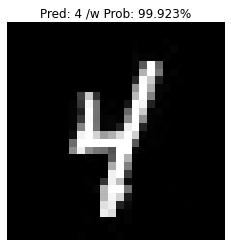

In [7]:
classes, oriImg = predictTFTRT(outputTensorrtPath, "test.jpg")
label = np.argmax(classes[0])
prob = classes[0][label] * 100.0

plt.figure()
plt.imshow(oriImg.numpy(), cmap='gray')
plt.axis("off")
plt.title("Pred: {} /w Prob: {:.3f}%".format(label, prob))
plt.show()

# TFTRT FP16 Model

['serving_default']
{'dense_5': TensorSpec(shape=<unknown>, dtype=tf.float32, name='dense_5')}


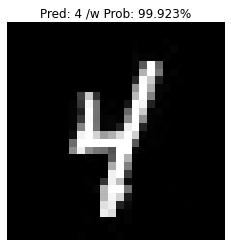

In [8]:
outputTensorrtFP16Path = "/tmp/mcclust/mnist_tensorrt_FP16"

classes, oriImg = predictTFTRT(outputTensorrtPath, "test.jpg")
label = np.argmax(classes[0])
prob = classes[0][label] * 100.0

plt.figure()
plt.imshow(oriImg.numpy(), cmap='gray')
plt.axis("off")
plt.title("Pred: {} /w Prob: {:.3f}%".format(label, prob))
plt.show()